# Experimentation and uplift testing

We will be examining the performance in trial vs control stores to provide a recommendation for each location based on our insight.

* Select control stores – explore the data and define metrics for control store selection – "What would make them a control store?" Visualize the drivers to see suitability.

* Assessment of the trial – get insights of each of the stores. Compare each trial store with ontrol store to get its overall performance. We want to know if the trial stores were successful or not.

* Collate findings – summarise findings for each store and provide recommendations to share with client outlining the impact on sales during trial period.

In [9]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date

In [10]:
# load dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/QVI_data1.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,10/17/2018,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,9/16/2018,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,3/7/2019,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,3/8/2019,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,11/2/2018,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


Give dataset desprictive name

In [12]:
# rename columns
df = df.rename(
    columns={
        'DATE': 'date',
        'STORE_NBR': 'store_number', 
        'LYLTY_CARD_NBR': 'loyalty_card_number', 
        'TXN_ID': 'transaction_ID',
        'PROD_NBR': 'product_number',
        'PROD_NAME': 'product_name',
        'PROD_QTY': 'product_quantity',
        'TOT_SALES': 'total_sales',
        'PACK_SIZE': 'pack_size',
        'BRAND': 'brand',
        'LIFESTAGE': 'lifestage',
        'PREMIUM_CUSTOMER': 'premium_customer'
        }
    )


# Select Control Stores


The client has selected store numbers 77, 86 and 88 as trial stores and want 
control stores to be established stores that are operational for the entire 
observation period.


We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer
- monthly number of chips per customer
- Average price per unit

First, we can filter the data to include only the stores that were present throughout the pre-trial period (before Feb 2019). We can do this by grouping the data by store number and counting the number of unique dates, and then selecting only the stores that have data for all dates before Feb 2019.

In [13]:
# Convert DATE column to datetime format
df['date'] = pd.to_datetime(df['date'])
df['date']

0        2018-10-17
1        2018-09-16
2        2019-03-07
3        2019-03-08
4        2018-11-02
            ...    
264829   2018-12-08
264830   2018-10-01
264831   2018-10-24
264832   2018-10-27
264833   2018-12-14
Name: date, Length: 264834, dtype: datetime64[ns]

### Add a new month ID column in the data with the format yyyymm

In [14]:
# Create a new column with the format yyyymm
df['month'] = df['date'].dt.strftime('%Y-%m')
df['month']


0         2018-10
1         2018-09
2         2019-03
3         2019-03
4         2018-11
           ...   
264829    2018-12
264830    2018-10
264831    2018-10
264832    2018-10
264833    2018-12
Name: month, Length: 264834, dtype: object

### Next, we define the measure calculations to use during the analysis.

For each store and month calculate **total sales, number of customers, transactions per customer, chips per customer and the average price per unit.**


In [15]:
# Calculate the metrics for each store and month
def monthly_store_metrics(df):
    # Total sales for each store in each month
    total_Sales = df.groupby(['store_number', 'month']).total_sales.sum()
    
    # Count of number of customers using specific store in each month
    customers = df.groupby(['store_number', 'month']).loyalty_card_number.nunique()

    # Transactions per customer for each store in each month
    transactions_per_customer = df.groupby(['store_number', 'month']).transaction_ID.nunique() / df.groupby(['store_number', 'month']).loyalty_card_number.nunique()

    # Total number of chips per transaction for each store and month
    chips_per_transaction = df.groupby(['store_number', 'month']).product_quantity.sum() / df.groupby(['store_number', 'month']).transaction_ID.nunique()

    # Monthly store average price per unit
    price_per_unit = df.groupby(['store_number', 'month']).total_sales.sum() / df.groupby(['store_number', 'month']).product_quantity.sum()

    # Combine the metrics into a single dataframe
    metrics_df = pd.concat([total_Sales, customers, transactions_per_customer, chips_per_transaction, price_per_unit], axis=1)
    metrics_df.columns = ['total_sales', 'number_customers', 'transactions_per_customer', 'chips_per_transaction', 'avg_price_per_unit']
    return metrics_df



# Reset the index to flatten the multi-level columns
metrics = monthly_store_metrics(df).reset_index()

# sort the metrics by store_number and month
metrics = metrics.sort_values(by=['store_number', 'month'])

metrics.head(8)

,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947
5,1,2018-12,189.6,42,1.119048,1.212766,3.326316
6,1,2019-01,154.8,35,1.028571,1.166667,3.685714
7,1,2019-02,225.4,52,1.057692,1.181818,3.467692


In [16]:
metrics.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   store_number               3169 non-null   int64  
 1   month                      3169 non-null   object 
 2   total_sales                3169 non-null   float64
 3   number_customers           3169 non-null   int64  
 4   transactions_per_customer  3169 non-null   float64
 5   chips_per_transaction      3169 non-null   float64
 6   avg_price_per_unit         3169 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 198.1+ KB


#### Filter to the pre-trial period and stores with full observation periods


In [17]:
# filter only stores with full 12 months observation
observ_counts = metrics['store_number'].value_counts()


# getting the store no. which have 12 months observations
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = metrics[metrics['store_number'].isin(full_observ_index)]
pre_trial_full_observ = full_observ[full_observ['month'] <= '2019-02']
pre_trial_full_observ

,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3160,272,2018-10,430.6,44,1.136364,1.980000,4.349495
3161,272,2018-11,376.2,41,1.097561,1.933333,4.324138
3162,272,2018-12,403.9,47,1.000000,1.893617,4.538202
3163,272,2019-01,423.0,46,1.086957,1.920000,4.406250


The resulting dataframe filters the metrics dataframe to include only stores with full 12 months of observation and then further filters to include only the pre-trial period (before Feb 2019)

### Now we need to work out a way of ranking how similar each potential control store is to the trial store. 


Let's write a function for this so that we don't have to calculate this for each trial store and control store pair. 


    """
    Args:
    inputTable (pandas.DataFrame): metric table with potential comparison stores 
    metricCol (str): store metric used to calculate correlation on e.g total_sale, number_customer
    storeComparison (int): store number of the trial store [77, 86, 88]
    """

In [18]:

import pandas as pd

def calculate_correlations(inputTable, metricCol, storeComparison):
    """
    Calculate correlation for a measure, looping through each control store.
    Args:
        metricCol (str): Name of column containing store's metric to perform correlation test on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.
        
    Returns:
        DataFrame: correlation table between Trial and each Control stores.
    """
    output = pd.DataFrame({'store 1': [], 'store 2': [], 'correlation': []})
    a = inputTable.loc[inputTable['store_number'] == storeComparison, metricCol]
    a.reset_index(drop=True, inplace=True)
    storeNumbers = inputTable['store_number'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['store_number'] == i, metricCol]
        b.reset_index(drop=True, inplace=True)
        correlation = b.corr(a)
        row = {'store 1': storeComparison, 'store 2': i, 'correlation': correlation}
        output = pd.concat([output, pd.DataFrame(row, index=[0])], ignore_index=True)
    return output



Apart from correlation, we can also calculate a standardised metric based on the 
absolute difference between the trial store's performance and each control store's 
performance.

In [19]:

import pandas as pd
import numpy as np

def calculate_magnitude_distance(inputTable, metricCol, storeComparison):
    """
    calculate standardised magnitude distance for a measure, looping through each control store.
    Args:
        metricCol (str): list of column containing store's metric to perform distance calculation on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.  
    Returns:
        DataFrame: Monthly magnitude-distance table between Trial and each Control stores.
    """
    output = pd.DataFrame({'store 1': [], 'store 2': [], 'magnitude': []})
    a = inputTable.loc[inputTable['store_number'] == storeComparison, metricCol]
    a.reset_index(drop=True, inplace=True)
    storeNumbers = inputTable['store_number'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['store_number'] == i, metricCol]
        b.reset_index(drop=True, inplace=True)
        c = abs(a - b)
        d = np.mean(1 - (c - min(c)) / (max(c) - min(c)))
        output = pd.concat([output, pd.DataFrame({'store 1': storeComparison, 'store 2': i, 'magnitude': d}, index=[0])], ignore_index=True)
    return output


We need to keep in mind that the client already selected stores 77, 86 and 88 as trial stores and we need the control stores to be similar to the trail stores prior to the trial period of Feb 2019 to compare them.

Now let's use the functions to find the control stores! We'll select control stores
based on how similar monthly total sales in dollar amounts and monthly number of 
customers are to the trial stores. So we will need to use our functions to get four
scores, two for each of total sales and total customers.

In [20]:
# We will use the two functions above to find the control store.
trial_store = 77
corr_nSales = calculate_correlations(pre_trial_full_observ, 'total_sales', storeComparison = trial_store)
corr_nCustomers = calculate_correlations(pre_trial_full_observ, 'number_customers', storeComparison = trial_store)

corr_nSales.head()


,store 1,store 2,correlation
0,77.0,1.0,0.050163
1,77.0,2.0,-0.200796
2,77.0,3.0,0.616574
3,77.0,4.0,-0.094125
4,77.0,5.0,-0.045765


In [21]:
corr_nCustomers.head()

,store 1,store 2,correlation
0,77.0,1.0,0.350572
1,77.0,2.0,-0.455226
2,77.0,3.0,0.756913
3,77.0,4.0,-0.302046
4,77.0,5.0,0.277619


In [22]:
magnitude_nSales = calculate_magnitude_distance(pre_trial_full_observ, 'total_sales', storeComparison=trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_full_observ, 'number_customers', storeComparison=trial_store)

magnitude_nSales.head()


,store 1,store 2,magnitude
0,77.0,1.0,0.451899
1,77.0,2.0,0.573994
2,77.0,3.0,0.569844
3,77.0,4.0,0.462734
4,77.0,5.0,0.575124


In [23]:
magnitude_nCustomers.head()

,store 1,store 2,magnitude
0,77.0,1.0,0.654412
1,77.0,2.0,0.544643
2,77.0,3.0,0.590909
3,77.0,4.0,0.462264
4,77.0,5.0,0.573529


We will concatenate the above two dataframes.

In [24]:
score_nSales = pd.concat([corr_nSales, magnitude_nSales['magnitude']], axis=1)

score_nSales.head()


,store 1,store 2,correlation,magnitude
0,77.0,1.0,0.050163,0.451899
1,77.0,2.0,-0.200796,0.573994
2,77.0,3.0,0.616574,0.569844
3,77.0,4.0,-0.094125,0.462734
4,77.0,5.0,-0.045765,0.575124


In [25]:
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['magnitude']], axis=1)

score_nCustomers.head()

,store 1,store 2,correlation,magnitude
0,77.0,1.0,0.350572,0.654412
1,77.0,2.0,-0.455226,0.544643
2,77.0,3.0,0.756913,0.590909
3,77.0,4.0,-0.302046,0.462264
4,77.0,5.0,0.277619,0.573529


We'll need to combine the all the scores calculated using our function to create a 
composite score to rank on. 
Let's take a simple average of the correlation and magnitude scores for each 
driver. Note that if we consider it more important for the trend of the drivers to 
be similar, we can increase the weight of the correlation score (a simple average 
gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of 
the drivers to be more important, we can lower the weight of the correlation score.

In [26]:
# A simple average on the scores would be 0.5 * corr_measure + 0.5 * mag_measure
corr_weight = 0.5
score_nSales['score_nSales'] = corr_weight * score_nSales['correlation'] + (1 - corr_weight) * score_nSales['magnitude']

score_nSales.head()

,store 1,store 2,correlation,magnitude,score_nSales
0,77.0,1.0,0.050163,0.451899,0.251031
1,77.0,2.0,-0.200796,0.573994,0.186599
2,77.0,3.0,0.616574,0.569844,0.593209
3,77.0,4.0,-0.094125,0.462734,0.184304
4,77.0,5.0,-0.045765,0.575124,0.264679


In [27]:
score_nCustomers['score_nCust'] = corr_weight * score_nCustomers['correlation'] + (1 - corr_weight) * score_nCustomers['magnitude']

score_nCustomers.head()

,store 1,store 2,correlation,magnitude,score_nCust
0,77.0,1.0,0.350572,0.654412,0.502492
1,77.0,2.0,-0.455226,0.544643,0.044708
2,77.0,3.0,0.756913,0.590909,0.673911
3,77.0,4.0,-0.302046,0.462264,0.080109
4,77.0,5.0,0.277619,0.573529,0.425574


Let us reset the index and concatenate the two dataframes above.

In [28]:
score_nSales.set_index(['store 1', 'store 2'], inplace = True)
score_nCustomers.set_index(['store 1', 'store 2'], inplace = True)


# concat score_nSales and score_nCustomers dataframe
composite_scores = pd.concat([score_nSales['score_nSales'], score_nCustomers['score_nCust']], axis = 1)

composite_scores



score_nSales  score_nCust
store 1 store 2                           
77.0    1.0          0.251031     0.502492
        2.0          0.186599     0.044708
        3.0          0.593209     0.673911
        4.0          0.184304     0.080109
        5.0          0.264679     0.425574
...                       ...          ...
        268.0        0.366743     0.405533
        269.0        0.119326     0.011798
        270.0        0.478402     0.202074
        271.0        0.370809     0.165356
        272.0        0.314378     0.420361

[260 rows x 2 columns]

Now we will compute the average of **score_nSales** and **score_nCust** and add it as a new column.

In [29]:
# Create a combined score composed of score_nSales and score_nCust 

composite_scores['combined_score'] = 0.5 * (composite_scores['score_nSales'] + composite_scores['score_nCust'])
composite_scores.head()



score_nSales  score_nCust  combined_score
store 1 store 2                                           
77.0    1.0          0.251031     0.502492        0.376761
        2.0          0.186599     0.044708        0.115653
        3.0          0.593209     0.673911        0.633560
        4.0          0.184304     0.080109        0.132207
        5.0          0.264679     0.425574        0.345127

In [30]:
# Top 5 highest Composite score for the Trial store based on combined_score
composite_scores.sort_values(by= 'combined_score', ascending=False).head()


score_nSales  score_nCust  combined_score
store 1 store 2                                           
77.0    233.0        0.712864     0.839021        0.775943
        119.0        0.597130     0.759688        0.678409
        17.0         0.629577     0.683098        0.656337
        115.0        0.717513     0.593774        0.655643
        71.0         0.691421     0.609718        0.650569

We can see that store 233 match store 77 better than others according to the combined_score. let's check visually if the drivers are indeed similar to store 77 before the trial period.

### Total Sales (store 77)

It's important to note that this is just a recommendation based on the analysis and there may be other factors that should be considered before finalizing the control stores.

In [31]:
# control_store
control_store = 233
trial_store = 77

pastSales = pre_trial_full_observ

# create new column within 'pastSales which categories store stype 
store_type = []

for i in pastSales['store_number']:
    if i == trial_store:
        store_type.append('trial store')
    elif i == control_store:
        store_type.append('control store')
    else:
        store_type.append('other stores')

pastSales['store_type'] = store_type
pastSales['store_type'].unique()
pastSales.head()

<ipython-input-31-eeb2f74de5b8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit,store_type
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097,other stores
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111,other stores
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333,other stores
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103,other stores
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947,other stores


Now that we have found a control store, let's check visually if the drivers are 
indeed similar in the period before the trial.
We'll look at total sales first.


In [32]:
# calculate mean sales for other stores
other_sales = pastSales.loc[pastSales['store_type'] == 'other stores', ['month', 'total_sales']]
other_sales_mean = other_sales.groupby('month').mean()
other_sales_mean.rename(columns={'total_sales': 'other stores'}, inplace=True)

# visual checks on Total Sales trends by comparing the trial store to the control store and other stores
store_types = ['control store', 'trial store', 'other stores']

sales_data = {}
for store_type in store_types:
    if store_type == 'other stores':
        sales = other_sales_mean
    else:
        sales = pastSales.loc[pastSales['store_type'] == store_type, ['month', 'total_sales']]
        sales.set_index('month', inplace=True)
        sales.rename(columns={'total_sales': store_type}, inplace=True)
    sales_data[store_type] = sales

control_store = sales_data['control store']
trial_store = sales_data['trial store']
other_stores = sales_data['other stores']

sales_data = pd.concat([control_store, trial_store, other_stores], axis=1)

sales_data


,control store,trial store,other stores
month,,,
2018-07,290.7,296.8,638.004651
2018-08,285.9,255.5,610.223450
2018-09,228.6,225.2,620.198450
2018-10,185.7,204.5,635.314729
2018-11,211.6,245.3,618.864341
2018-12,279.8,267.3,648.453876
2019-01,177.5,204.4,628.684496
2019-02,244.0,235.0,581.887597


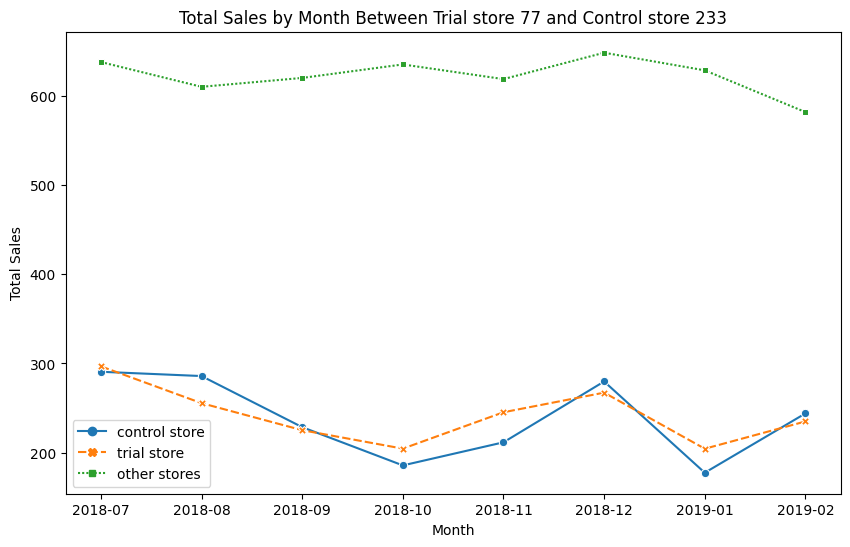

In [33]:

import seaborn as sns

# plot for each store: Trial store 77: control store 233
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_data, markers=True)
plt.title('Total Sales by Month Between Trial store 77 and Control store 233')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.show()




Based on the line plot, we can see that the Total Sales trend for the control store (Store 233) is very similar to the trend for the trial store (Store 77) before the trial period, while the trends for other stores are quite different. This confirms that Store 233 is a good candidate for a control store during the trial period.

### Number of Customers (store 77)

The same steps can be repeated for Number of Customers

In [34]:
# calculate mean customers for other stores
other_customers = pastSales.loc[pastSales['store_type'] == 'other stores', ['month', 'number_customers']]
other_customers_mean = other_customers.groupby('month').mean()
other_customers_mean.rename(columns={'number_customers': 'other stores'}, inplace=True)

# visual checks on Number Customers trends by comparing the trial store to the control store and other stores
store_types = ['control store', 'trial store', 'other stores']

customers_data = {}
for store_type in store_types:
    if store_type == 'other stores':
        customers = other_customers_mean
    else:
        customers = pastSales.loc[pastSales['store_type'] == store_type, ['month', 'number_customers']]
        customers.set_index('month', inplace=True)
        customers.rename(columns={'number_customers': store_type}, inplace=True)
    customers_data[store_type] = customers

control_store = customers_data['control store']
trial_store = customers_data['trial store']
other_stores = customers_data['other stores']

customers_data = pd.concat([control_store, trial_store, other_stores], axis=1)

customers_data


,control store,trial store,other stores
month,,,
2018-07,51,51,72.333333
2018-08,48,47,72.120155
2018-09,42,42,70.131783
2018-10,35,37,71.608527
2018-11,40,41,70.534884
2018-12,47,46,73.515504
2019-01,35,35,71.240310
2019-02,45,45,66.476744


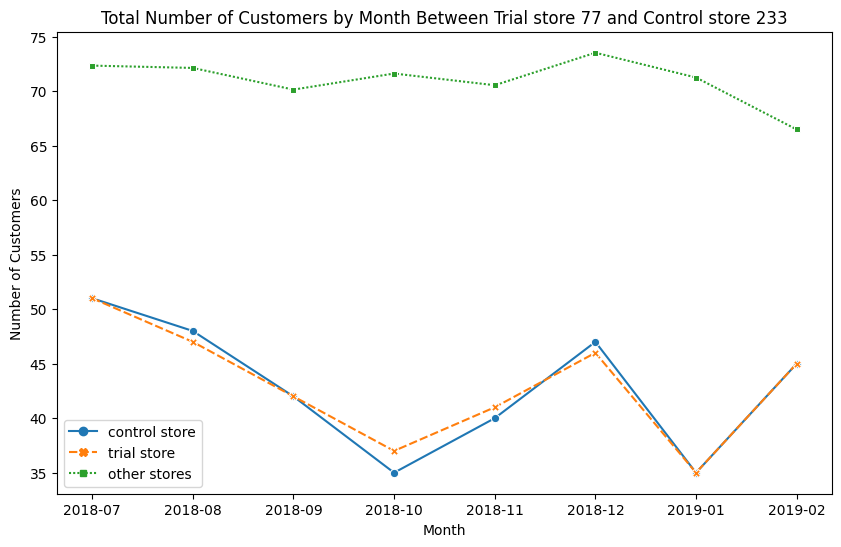

In [35]:
# plot for each store: Trial store 77: Control Store 233
plt.figure(figsize=(10, 6))
sns.lineplot(data=customers_data, markers=True)
plt.title('Total Number of Customers by Month Between Trial store 77 and Control store 233')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()



## Assessment of trial
The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an uplift in overall chip sales.

We’ll start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.

### Trial store 77


In [36]:
# Scale pre‐trial control sales to match pre‐trial trial store sales
scaling_factor_controlSales = pastSales[(pastSales['store_type'] == 'trial store') & (pastSales['month'] < '2019-02')]['total_sales'].sum() / \
                                 pastSales[(pastSales['store_type'] == 'control store') & (pastSales['month'] < '2019-02')]['total_sales'].sum()      

print('Scaling factor for control sales:', scaling_factor_controlSales)    


Scaling factor for control sales: 1.023617303289553


Applying the Scaling factor

In [37]:
# Apply the scaling factor
control_store = 233
scaled_ControlSales = metrics.loc[metrics['store_number'] == control_store]

scaled_ControlSales['control_sales'] = scaled_ControlSales['total_sales'] * scaling_factor_controlSales
scaled_ControlSales.head()


<ipython-input-37-12a614496e9d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_ControlSales['control_sales'] = scaled_ControlSales['total_sales'] * scaling_factor_controlSales


,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit,control_sales
2699,233,2018-07,290.7,51,1.058824,1.629630,3.303409,297.565550
2700,233,2018-08,285.9,48,1.041667,1.600000,3.573750,292.652187
2701,233,2018-09,228.6,42,1.071429,1.555556,3.265714,233.998916
2702,233,2018-10,185.7,35,1.028571,1.555556,3.316071,190.085733
2703,233,2018-11,211.6,40,1.025000,1.512195,3.412903,216.597421


Calculate the percentage difference between scaled control sales and trial sales.




In [38]:
# Create 'percentage_diff' dataframec and merge the scaled control sales and trial sales based on month
trial_store = 77
merged_sales = scaled_ControlSales[['month', 'control_sales']].merge(metrics[metrics['store_number'] == trial_store][['total_sales', 'month']],
                                                                     on='month', how='inner')

merged_sales.rename(columns={'total_sales': 'trial_sales'}, inplace=True)

merged_sales['percentage_diff'] = abs(merged_sales['control_sales'] - merged_sales['trial_sales']) / merged_sales['control_sales']

merged_sales



,month,control_sales,trial_sales,percentage_diff
0,2018-07,297.565550,296.8,0.002573
1,2018-08,292.652187,255.5,0.126950
2,2018-09,233.998916,225.2,0.037602
3,2018-10,190.085733,204.5,0.075830
4,2018-11,216.597421,245.3,0.132516
5,2018-12,286.408121,267.3,0.066716
6,2019-01,181.692071,204.4,0.124980
7,2019-02,249.762622,235.0,0.059107
8,2019-03,203.802205,278.5,0.366521
9,2019-04,162.345704,263.5,0.623080


Let’s see if the difference is significant!

In [39]:
# As our null hypothesis is that the trial period is the same as the  pre‐trial period, 
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

# Statistics Libraries
from statistics import stdev
from scipy.stats import t


# calculate standard deviation of percentage difference during pre-trial period
stdDev = stdev(merged_sales.loc[merged_sales['month'] < '2019-02', 'percentage_diff'])
print(f'Standard deviation: {stdDev} \n')


# note that there are 8 months in the pre‐trial period hence 8 ‐ 1 = 7 degrees of freedom
degrees_of_freedom = 7

# We will test with a null hypothesis of there being 0 difference between  trial and control stores.
merged_sales['tValue'] = (merged_sales['percentage_diff'] - 0) / stdDev
t_values = merged_sales.loc[(merged_sales['month'] < '2019-05') & (merged_sales['month'] > '2019-01'), ['month', 'tValue']]
print(t_values)


# calculate 95th percentile of t-distribution with appropriate degrees of freedom
t_crit = t.ppf(0.95, df=degrees_of_freedom)
print(f'\n T-critical value: {t_crit}')


Standard deviation: 0.049940762641425364 

     month     tValue
7  2019-02   1.183534
8  2019-03   7.339116
9  2019-04  12.476373

 T-critical value: 1.894578605061305


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store.

Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores
and the 95th percentile value of sales of the control store.

In [40]:
# calculate for the 95th percentile value of sales of the control store.
sale_over_time = merged_sales.loc[:, ['month','control_sales', 'trial_sales']]
sale_over_time['control 95% confidence interval'] = sale_over_time['control_sales'] * (1 + stdDev * 2)
sale_over_time['control 5% confidence interval'] = sale_over_time['control_sales'] * (1 - stdDev * 2)
sale_over_time['transaction_month'] = pd.to_datetime(sale_over_time['month'].astype(str), format = '%Y-%m')

combineSales = sale_over_time.loc[:, ['transaction_month','control_sales', 'trial_sales', 'control 95% confidence interval', 'control 5% confidence interval']].set_index('transaction_month')

combineSales


,control_sales,trial_sales,control 95% confidence interval,control 5% confidence interval
transaction_month,,,,
2018-07-01,297.565550,296.8,327.286851,267.844249
2018-08-01,292.652187,255.5,321.882734,263.421640
2018-09-01,233.998916,225.2,257.371084,210.626747
2018-10-01,190.085733,204.5,209.071786,171.099680
2018-11-01,216.597421,245.3,238.231502,194.963341
2018-12-01,286.408121,267.3,315.015001,257.801241
2019-01-01,181.692071,204.4,199.839753,163.544390
2019-02-01,249.762622,235.0,274.709294,224.815950
2019-03-01,203.802205,278.5,224.158280,183.446130


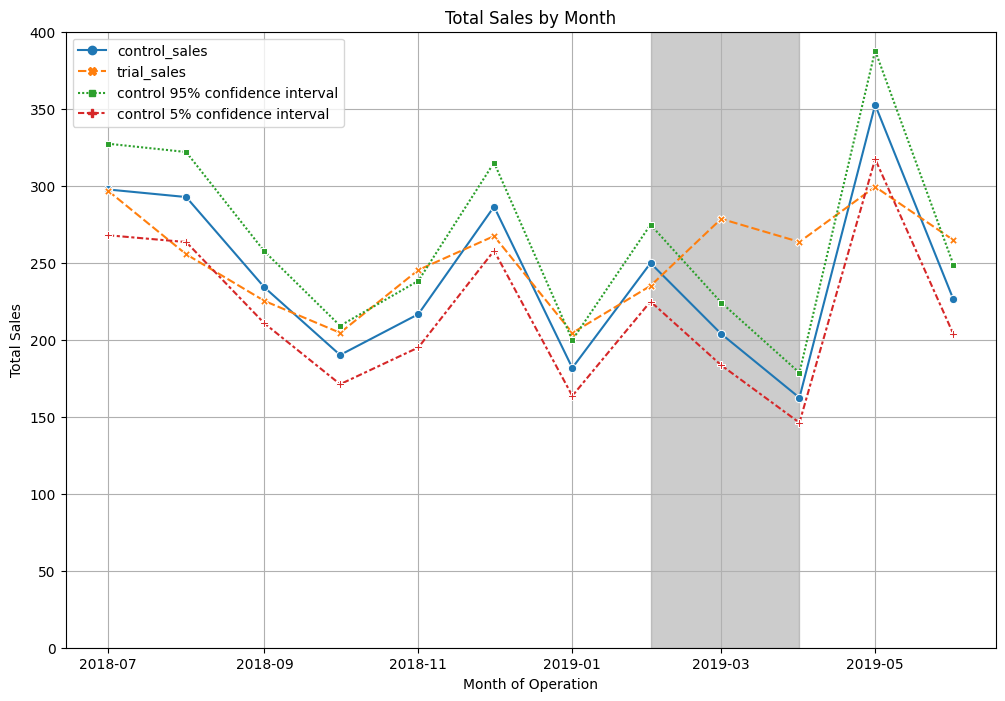

In [41]:
import matplotlib.dates as mdates

# Create plot for sales over time for control store and trial store
plt.figure(figsize = (12, 8))
sns.lineplot(data=combineSales, markers=True)

plt.title('Total Sales by Month Between Trial store 77 and Control store 233')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.ylim((0, 400))
plt.axvspan(* mdates.datestr2num(['2019-02-01', '2019-04-01']), color='grey', alpha = 0.4)
plt.legend()
plt.grid()
plt.show()


The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.

We will repeat almost the same procedures for Number of Customers.

In [42]:
# Scale pre‐trial control customers to match pre‐trial trial store customers
scaling_factor_controlCustomers = pastSales[(pastSales['store_type'] == 'trial store') & (pastSales['month'] < '2019-02')]['number_customers'].sum() / \
                                 pastSales[(pastSales['store_type'] == 'control store') & (pastSales['month'] < '2019-02')]['number_customers'].sum()      

print('Scaling factor for control sales:', scaling_factor_controlCustomers)


Scaling factor for control sales: 1.0033557046979866


In [43]:
# Apply the scaling factor
control_store = 233
scaled_ControlCustomers = metrics.loc[metrics['store_number'] == control_store]

scaled_ControlCustomers['control_customers'] = scaled_ControlCustomers['number_customers'] * scaling_factor_controlCustomers
scaled_ControlCustomers.head()


<ipython-input-43-3db01c89941e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_ControlCustomers['control_customers'] = scaled_ControlCustomers['number_customers'] * scaling_factor_controlCustomers


,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit,control_customers
2699,233,2018-07,290.7,51,1.058824,1.629630,3.303409,51.171141
2700,233,2018-08,285.9,48,1.041667,1.600000,3.573750,48.161074
2701,233,2018-09,228.6,42,1.071429,1.555556,3.265714,42.140940
2702,233,2018-10,185.7,35,1.028571,1.555556,3.316071,35.117450
2703,233,2018-11,211.6,40,1.025000,1.512195,3.412903,40.134228


In [44]:
# Create 'percentage_diff' dataframe and merge the scaled control Customers and trial Customers based on month
trial_store = 77
merged_Customers = scaled_ControlCustomers[['month', 'control_customers']].merge(metrics[metrics['store_number'] == trial_store][['number_customers', 'month']],
                                                                     on='month', how='inner')

merged_Customers.rename(columns={'number_customers': 'trial_customers'}, inplace=True)

merged_Customers['percentage_diff'] = abs(merged_Customers['control_customers'] - merged_Customers['trial_customers']) / merged_Customers['control_customers']

merged_Customers

,month,control_customers,trial_customers,percentage_diff
0,2018-07,51.171141,51,0.003344
1,2018-08,48.161074,47,0.024108
2,2018-09,42.140940,42,0.003344
3,2018-10,35.117450,37,0.053607
4,2018-11,40.134228,41,0.021572
5,2018-12,47.157718,46,0.024550
6,2019-01,35.117450,35,0.003344
7,2019-02,45.151007,45,0.003344
8,2019-03,40.134228,50,0.245819
9,2019-04,30.100671,47,0.561427


In [45]:
# As our null hypothesis is that the trial period is the same as the  pre‐trial period, 
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

# Statistics Libraries
from statistics import stdev
from scipy.stats import t


# calculate standard deviation of percentage difference during pre-trial period
stdDev = stdev(merged_Customers.loc[merged_Customers['month'] < '2019-02', 'percentage_diff'])
print(f'Standard deviation: {stdDev} \n')


# note that there are 8 months in the pre‐trial period hence 8 ‐ 1 = 7 degrees of freedom
degrees_of_freedom = 7

# We will test with a null hypothesis of there being 0 difference between  trial and control stores.
merged_Customers['tValue'] = (merged_Customers['percentage_diff'] - 0) / stdDev
t_values = merged_Customers.loc[(merged_Customers['month'] < '2019-05') & (merged_Customers['month'] > '2019-01'), ['month', 'tValue']]
print(t_values)


# calculate 95th percentile of t-distribution with appropriate degrees of freedom
t_crit = t.ppf(0.95, df=degrees_of_freedom)
print(f'\n T-critical value: {t_crit}')


Standard deviation: 0.018240748558243945 

     month     tValue
7  2019-02   0.183352
8  2019-03  13.476388
9  2019-04  30.778725

 T-critical value: 1.894578605061305


We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March and April.

In [46]:
# calculate for the 95th percentile value of sales of the control store.
customers_over_time = merged_Customers.loc[:, ['month','control_customers', 'trial_customers']]
customers_over_time['control 95% confidence interval'] = customers_over_time ['control_customers'] * (1 + stdDev * 2)
customers_over_time['control 5% confidence interval'] = customers_over_time ['control_customers'] * (1 - stdDev * 2)
customers_over_time['transaction_month'] = pd.to_datetime(customers_over_time ['month'].astype(str), format = '%Y-%m')

combinecustomers = customers_over_time.loc[:, ['transaction_month','control_customers', 'trial_customers', 'control 95% confidence interval', 'control 5% confidence interval']].set_index('transaction_month')

combinecustomers



,control_customers,trial_customers,control 95% confidence interval,control 5% confidence interval
transaction_month,,,,
2018-07-01,51.171141,51,53.037941,49.304341
2018-08-01,48.161074,47,49.918062,46.404086
2018-09-01,42.140940,42,43.678304,40.603575
2018-10-01,35.117450,37,36.398587,33.836313
2018-11-01,40.134228,41,41.598385,38.670071
2018-12-01,47.157718,46,48.878102,45.437334
2019-01-01,35.117450,35,36.398587,33.836313
2019-02-01,45.151007,45,46.798183,43.503830
2019-03-01,40.134228,50,41.598385,38.670071


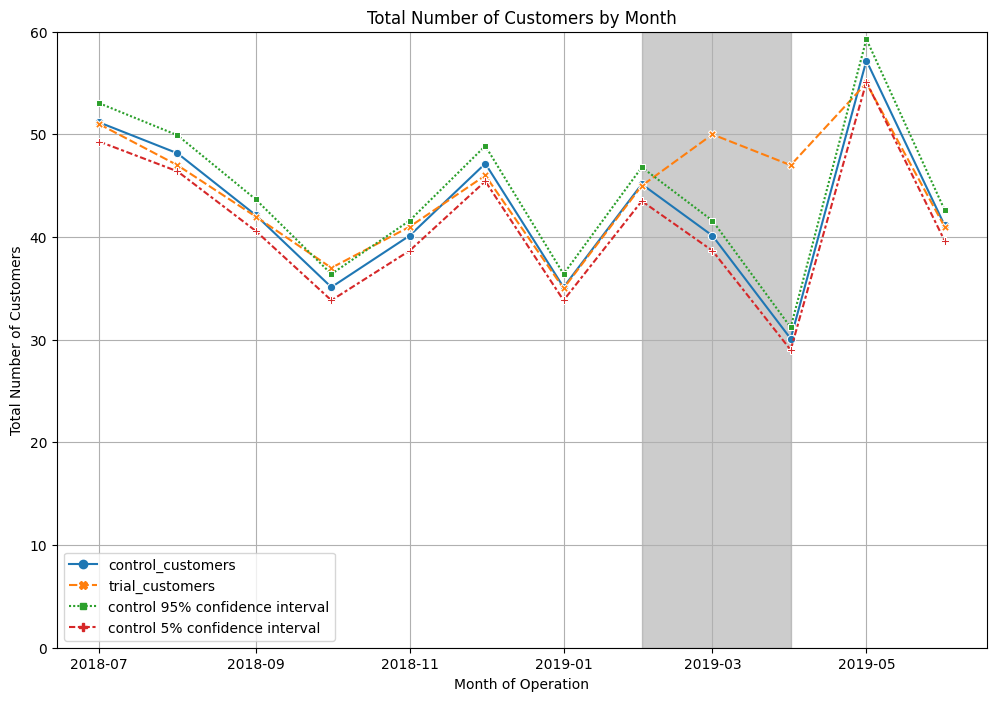

In [47]:
# Create plot for customers over time for control store and trial store
plt.figure(figsize = (12, 8))
sns.lineplot(data=combinecustomers, markers=True)

plt.title('Total Numbeer of Customers by Month Between Trial store 77 and Control store 233')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.ylim((0, 60))
plt.axvspan(* mdates.datestr2num(['2019-02-01', '2019-04-01']), color='grey', alpha = 0.4)
plt.legend()
plt.grid()
plt.show()




The same procedures achieved above can be repeated for finding the control store and assessing the impact of the trial for the two remaining trial stores, 86 and 88.

### Trial store 86

In [48]:
# We will use the two functions above to find the control store.
trial_store = 86
corr_nSales = calculate_correlations(pre_trial_full_observ, 'total_sales', storeComparison = trial_store)
corr_nCustomers = calculate_correlations(pre_trial_full_observ, 'number_customers', storeComparison = trial_store)

corr_nSales.head()


,store 1,store 2,correlation
0,86.0,1.0,0.478355
1,86.0,2.0,-0.453556
2,86.0,3.0,-0.081104
3,86.0,4.0,-0.204603
4,86.0,5.0,0.067263


In [49]:
corr_nCustomers.head()

,store 1,store 2,correlation
0,86.0,1.0,0.559062
1,86.0,2.0,-0.428881
2,86.0,3.0,0.026475
3,86.0,4.0,-0.462982
4,86.0,5.0,-0.391022


In [50]:
magnitude_nSales = calculate_magnitude_distance(pre_trial_full_observ, 'total_sales', storeComparison=trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_full_observ, 'number_customers', storeComparison=trial_store)

magnitude_nSales.head()


,store 1,store 2,magnitude
0,86.0,1.0,0.479874
1,86.0,2.0,0.285031
2,86.0,3.0,0.461317
3,86.0,4.0,0.464945
4,86.0,5.0,0.579356


In [51]:
magnitude_nCustomers.head()

,store 1,store 2,magnitude
0,86.0,1.0,0.505952
1,86.0,2.0,0.560185
2,86.0,3.0,0.558824
3,86.0,4.0,0.558824
4,86.0,5.0,0.631579


We will concatenate the above two dataframes.

In [52]:
score_nSales = pd.concat([corr_nSales, magnitude_nSales['magnitude']], axis=1)

score_nSales.head()


,store 1,store 2,correlation,magnitude
0,86.0,1.0,0.478355,0.479874
1,86.0,2.0,-0.453556,0.285031
2,86.0,3.0,-0.081104,0.461317
3,86.0,4.0,-0.204603,0.464945
4,86.0,5.0,0.067263,0.579356


In [53]:
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['magnitude']], axis=1)

score_nCustomers.head()

,store 1,store 2,correlation,magnitude
0,86.0,1.0,0.559062,0.505952
1,86.0,2.0,-0.428881,0.560185
2,86.0,3.0,0.026475,0.558824
3,86.0,4.0,-0.462982,0.558824
4,86.0,5.0,-0.391022,0.631579


We'll need to combine the all the scores calculated using our function to create a composite score to rank on. Let's take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [54]:
# A simple average on the scores would be 0.5 * corr_measure + 0.5 * mag_measure
corr_weight = 0.5
score_nSales['score_nSales'] = corr_weight * score_nSales['correlation'] + (1 - corr_weight) * score_nSales['magnitude']

score_nSales.head()

,store 1,store 2,correlation,magnitude,score_nSales
0,86.0,1.0,0.478355,0.479874,0.479114
1,86.0,2.0,-0.453556,0.285031,-0.084263
2,86.0,3.0,-0.081104,0.461317,0.190107
3,86.0,4.0,-0.204603,0.464945,0.130171
4,86.0,5.0,0.067263,0.579356,0.323310


In [55]:

score_nCustomers['score_nCust'] = corr_weight * score_nCustomers['correlation'] + (1 - corr_weight) * score_nCustomers['magnitude']

score_nCustomers.head()

,store 1,store 2,correlation,magnitude,score_nCust
0,86.0,1.0,0.559062,0.505952,0.532507
1,86.0,2.0,-0.428881,0.560185,0.065652
2,86.0,3.0,0.026475,0.558824,0.292649
3,86.0,4.0,-0.462982,0.558824,0.047921
4,86.0,5.0,-0.391022,0.631579,0.120279


In [56]:
score_nSales.set_index(['store 1', 'store 2'], inplace = True)
score_nCustomers.set_index(['store 1', 'store 2'], inplace = True)


# concat score_nSales and score_nCustomers dataframe
composite_scores = pd.concat([score_nSales['score_nSales'], score_nCustomers['score_nCust']], axis = 1)

composite_scores

score_nSales  score_nCust
store 1 store 2                           
86.0    1.0          0.479114     0.532507
        2.0         -0.084263     0.065652
        3.0          0.190107     0.292649
        4.0          0.130171     0.047921
        5.0          0.323310     0.120279
...                       ...          ...
        268.0       -0.111331     0.148270
        269.0        0.605918     0.189553
        270.0       -0.087378    -0.082253
        271.0        0.462116     0.291157
        272.0        0.287495     0.178030

[260 rows x 2 columns]

Now we will compute the average of score_nSales and score_nCust and add it as a new column.

In [57]:
# Create a combined score composed of score_nSales and score_nCust 

composite_scores['combined_score'] = 0.5 * (composite_scores['score_nSales'] + composite_scores['score_nCust'])
composite_scores.head()



score_nSales  score_nCust  combined_score
store 1 store 2                                           
86.0    1.0          0.479114     0.532507        0.505811
        2.0         -0.084263     0.065652       -0.009305
        3.0          0.190107     0.292649        0.241378
        4.0          0.130171     0.047921        0.089046
        5.0          0.323310     0.120279        0.221794

In [58]:
# Top 5 highest Composite score for the Trial store based on combined_score
composite_scores.sort_values(by= 'combined_score', ascending=False).head()


score_nSales  score_nCust  combined_score
store 1 store 2                                           
86.0    155.0        0.797131     0.708476        0.752803
        109.0        0.616055     0.572961        0.594508
        260.0        0.573687     0.592875        0.583281
        232.0        0.647406     0.507578        0.577492
        229.0        0.485546     0.639775        0.562660

Looks like store 155 will be a control store for trial store 86. Again, let’s check visually if the drivers are
indeed similar in the period before the trial.

We’ll look at total sales first.

In [59]:
# control_store
control_store = 155

pastSales = pre_trial_full_observ

# create new column within 'pastSales which categories store stype 
store_type = []

for i in pastSales['store_number']:
    if i == trial_store:
        store_type.append('trial store')
    elif i == control_store:
        store_type.append('control store')
    else:
        store_type.append('other stores')

pastSales['store_type'] = store_type
pastSales['store_type'].unique()
pastSales.head()

<ipython-input-59-92a4803be4e1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit,store_type
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097,other stores
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111,other stores
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333,other stores
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103,other stores
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947,other stores


Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial. We'll look at total sales first.

In [60]:
# calculate mean sales for other stores
other_sales = pastSales.loc[pastSales['store_type'] == 'other stores', ['month', 'total_sales']]
other_sales_mean = other_sales.groupby('month').mean()
other_sales_mean.rename(columns={'total_sales': 'other stores'}, inplace=True)

# visual checks on Total Sales trends by comparing the trial store to the control store and other stores
store_types = ['control store', 'trial store', 'other stores']

sales_data = {}
for store_type in store_types:
    if store_type == 'other stores':
        sales = other_sales_mean
    else:
        sales = pastSales.loc[pastSales['store_type'] == store_type, ['month', 'total_sales']]
        sales.set_index('month', inplace=True)
        sales.rename(columns={'total_sales': store_type}, inplace=True)
    sales_data[store_type] = sales

control_store = sales_data['control store']
trial_store = sales_data['trial store']
other_stores = sales_data['other stores']

sales_data = pd.concat([control_store, trial_store, other_stores], axis=1)

sales_data


,control store,trial store,other stores
month,,,
2018-07,924.6,892.20,633.239922
2018-08,782.7,764.05,606.326744
2018-09,1014.4,914.60,614.480620
2018-10,963.8,948.40,629.415504
2018-11,898.8,918.00,613.593411
2018-12,849.8,841.20,644.020155
2019-01,874.6,841.40,623.513566
2019-02,891.2,913.20,576.750388


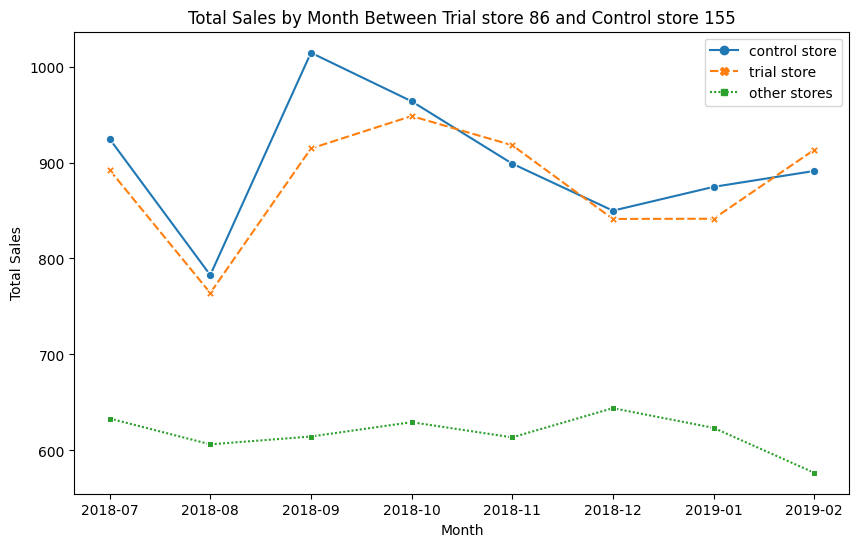

In [61]:
import seaborn as sns

# plot for each store: Trial store 86: control store 155
plt.figure(figsize=(10, 6))
sns.lineplot(data=sales_data, markers=True)
plt.title('Total Sales by Month Between Trial store 86 and Control store 155')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.show()



Great, sales are trending in a similar way.

The same steps can be repeated for Number of Customers

In [62]:
# calculate mean customers for other stores
other_customers = pastSales.loc[pastSales['store_type'] == 'other stores', ['month', 'number_customers']]
other_customers_mean = other_customers.groupby('month').mean()
other_customers_mean.rename(columns={'number_customers': 'other stores'}, inplace=True)

# visual checks on Number Customers trends by comparing the trial store to the control store and other stores
store_types = ['control store', 'trial store', 'other stores']

customers_data = {}
for store_type in store_types:
    if store_type == 'other stores':
        customers = other_customers_mean
    else:
        customers = pastSales.loc[pastSales['store_type'] == store_type, ['month', 'number_customers']]
        customers.set_index('month', inplace=True)
        customers.rename(columns={'number_customers': store_type}, inplace=True)
    customers_data[store_type] = customers

control_store = customers_data['control store']
trial_store = customers_data['trial store']
other_stores = customers_data['other stores']

customers_data = pd.concat([control_store, trial_store, other_stores], axis=1)

customers_data


,control store,trial store,other stores
month,,,
2018-07,101,99,71.953488
2018-08,91,94,71.771318
2018-09,103,103,69.658915
2018-10,108,109,71.046512
2018-11,101,100,70.069767
2018-12,97,98,73.120155
2019-01,96,94,70.775194
2019-02,95,107,66.042636


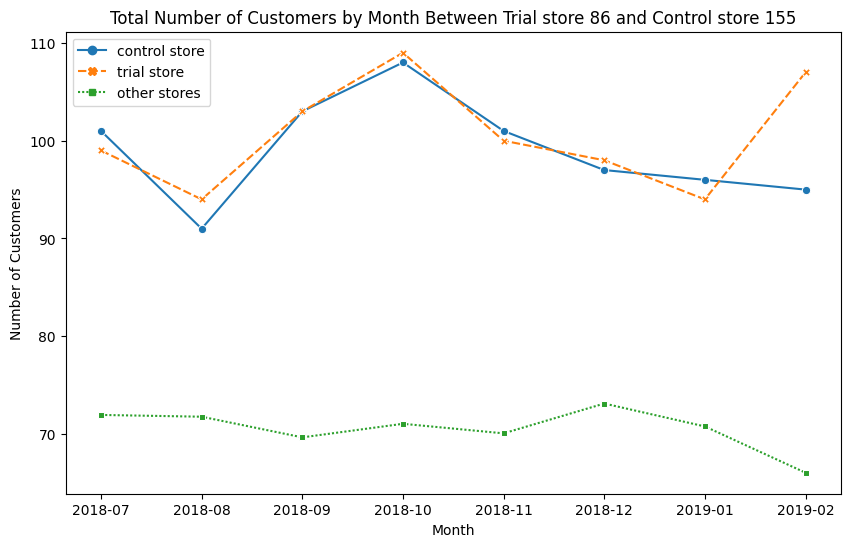

In [63]:
# plot for each store: Trial store 86: Control Store 155
plt.figure(figsize=(10, 6))
sns.lineplot(data=customers_data, markers=True)
plt.title('Total Number of Customers by Month Between Trial store 86 and Control store 155')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()



Good, the trend in number of customers is also similar.

Let’s now assess the impact of the trial on sales.

In [64]:
# Scale pre‐trial control sales to match pre‐trial trial store sales
scaling_factor_controlSales = pastSales[(pastSales['store_type'] == 'trial store') & (pastSales['month'] < '2019-02')]['total_sales'].sum() / \
                                 pastSales[(pastSales['store_type'] == 'control store') & (pastSales['month'] < '2019-02')]['total_sales'].sum()      

print('Scaling factor for control sales:', scaling_factor_controlSales)


Scaling factor for control sales: 0.9700651481287743


In [65]:
# Apply the scaling factor
control_store = 155
scaled_ControlSales = metrics.loc[metrics['store_number'] == control_store]

scaled_ControlSales['control_sales'] = scaled_ControlSales['total_sales'] * scaling_factor_controlSales
scaled_ControlSales.head()


<ipython-input-65-a0132e6edbe0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_ControlSales['control_sales'] = scaled_ControlSales['total_sales'] * scaling_factor_controlSales


,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit,control_sales
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,896.922236
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,759.269991
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,984.034086
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,934.948790
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,871.894555


In [66]:
# Create 'percentage_diff' dataframec and merge the scaled control sales and trial sales based on month
trial_store = 86
merged_sales = scaled_ControlSales[['month', 'control_sales']].merge(metrics[metrics['store_number'] == trial_store][['total_sales', 'month']],
                                                                     on='month', how='inner')

merged_sales.rename(columns={'total_sales': 'trial_sales'}, inplace=True)

merged_sales['percentage_diff'] = abs(merged_sales['control_sales'] - merged_sales['trial_sales']) / merged_sales['control_sales']

merged_sales



,month,control_sales,trial_sales,percentage_diff
0,2018-07,896.922236,892.20,0.005265
1,2018-08,759.269991,764.05,0.006296
2,2018-09,984.034086,914.60,0.070561
3,2018-10,934.948790,948.40,0.014387
4,2018-11,871.894555,918.00,0.052880
5,2018-12,824.361363,841.20,0.020426
6,2019-01,848.418979,841.40,0.008273
7,2019-02,864.522060,913.20,0.056306
8,2019-03,780.320405,1026.80,0.315870
9,2019-04,819.317024,848.20,0.035253


In [67]:
# As our null hypothesis is that the trial period is the same as the  pre‐trial period, 
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

# Statistics Libraries
from statistics import stdev
from scipy.stats import t


# calculate standard deviation of percentage difference during pre-trial period
stdDev = stdev(merged_sales.loc[merged_sales['month'] < '2019-02', 'percentage_diff'])
print(f'Standard deviation: {stdDev} \n')


# note that there are 8 months in the pre‐trial period hence 8 ‐ 1 = 7 degrees of freedom
degrees_of_freedom = 7

# We will test with a null hypothesis of there being 0 difference between  trial and control stores.
merged_sales['tValue'] = (merged_sales['percentage_diff'] - 0) / stdDev
t_values = merged_sales.loc[(merged_sales['month'] < '2019-05') & (merged_sales['month'] > '2019-01'), ['month', 'tValue']]
print(t_values)


# calculate 95th percentile of t-distribution with appropriate degrees of freedom
t_crit = t.ppf(0.95, df=degrees_of_freedom)
print(f'\n T-critical value: {t_crit}')


Standard deviation: 0.02583395285477237 

     month     tValue
7  2019-02   2.179542
8  2019-03  12.226922
9  2019-04   1.364580

 T-critical value: 1.894578605061305


In [68]:
# calculate for the 95th percentile value of sales of the control store.
sale_over_time = merged_sales.loc[:, ['month','control_sales', 'trial_sales']]
sale_over_time['control 95% confidence interval'] = sale_over_time['control_sales'] * (1 + stdDev * 2)
sale_over_time['control 5% confidence interval'] = sale_over_time['control_sales'] * (1 - stdDev * 2)
sale_over_time['transaction_month'] = pd.to_datetime(sale_over_time['month'].astype(str), format = '%Y-%m')

combineSales = sale_over_time.loc[:, ['transaction_month','control_sales', 'trial_sales', 'control 95% confidence interval', 'control 5% confidence interval']].set_index('transaction_month')

combineSales


,control_sales,trial_sales,control 95% confidence interval,control 5% confidence interval
transaction_month,,,,
2018-07-01,896.922236,892.20,943.264329,850.580142
2018-08-01,759.269991,764.05,798.499882,720.040101
2018-09-01,984.034086,914.60,1034.877067,933.191106
2018-10-01,934.948790,948.40,983.255636,886.641944
2018-11-01,871.894555,918.00,916.943521,826.845589
2018-12-01,824.361363,841.20,866.954388,781.768338
2019-01-01,848.418979,841.40,892.255010,804.582947
2019-02-01,864.522060,913.20,909.190104,819.854016
2019-03-01,780.320405,1026.80,820.637926,740.002884


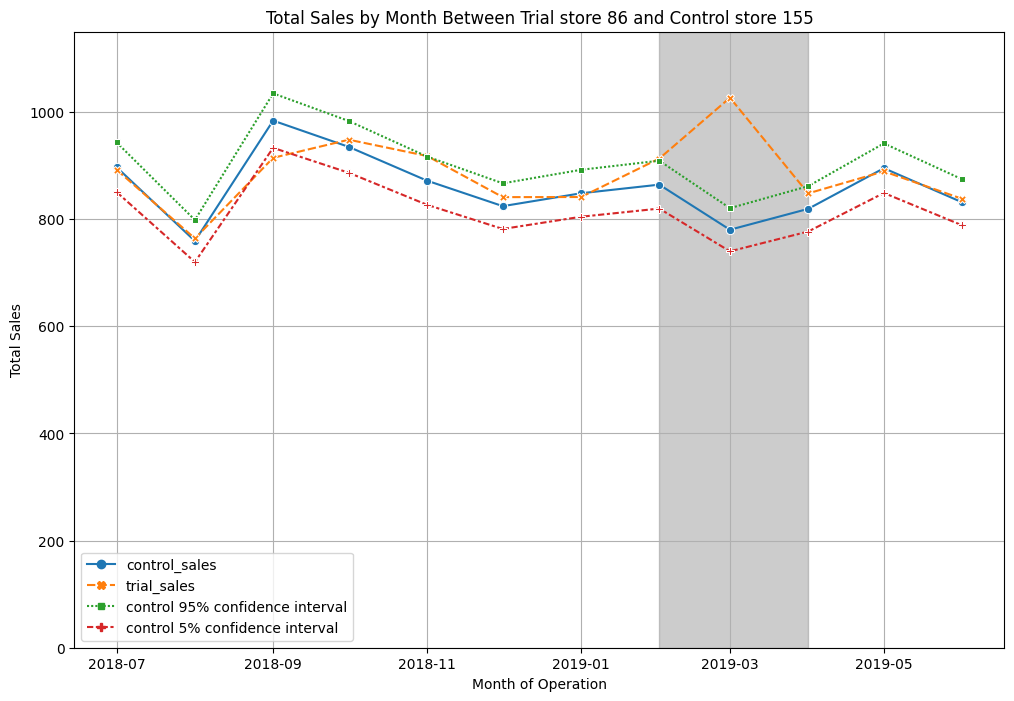

In [69]:
import matplotlib.dates as mdates

# Create plot for sales over time for control store and trial store
plt.figure(figsize = (12, 8))
sns.lineplot(data=combineSales, markers=True)

plt.title('Total Sales by Month Between Trial store 86 and Control store 155')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.ylim((0, 1150))
plt.axvspan(* mdates.datestr2num(['2019-02-01', '2019-04-01']), color='grey', alpha = 0.4)
plt.legend()
plt.grid()
plt.show()


The results show that the trial in store 86 is not significantly different to its control store in the trial period
as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
three trial months.

Let’s have a look at assessing this for number of customers as well.

In [70]:
# Scale pre‐trial control customers to match pre‐trial trial store customers
scaling_factor_controlCustomers = pastSales[(pastSales['store_type'] == 'trial store') & (pastSales['month'] < '2019-02')]['number_customers'].sum() / \
                                 pastSales[(pastSales['store_type'] == 'control store') & (pastSales['month'] < '2019-02')]['number_customers'].sum()      

print('Scaling factor for control sales:', scaling_factor_controlCustomers)


Scaling factor for control sales: 1.0


In [71]:
# Apply the scaling factor
control_store = 155
scaled_ControlCustomers = metrics.loc[metrics['store_number'] == control_store]

scaled_ControlCustomers['control_customers'] = scaled_ControlCustomers['number_customers'] * scaling_factor_controlCustomers
scaled_ControlCustomers.head()


<ipython-input-71-6c1a53760954>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_ControlCustomers['control_customers'] = scaled_ControlCustomers['number_customers'] * scaling_factor_controlCustomers


,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit,control_customers
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,101.0
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,91.0
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,103.0
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,108.0
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,101.0


In [72]:
# Create 'percentage_diff' dataframe and merge the scaled control Customers and trial Customers based on month
trial_store = 86
merged_Customers = scaled_ControlCustomers[['month', 'control_customers']].merge(metrics[metrics['store_number'] == trial_store][['number_customers', 'month']],
                                                                     on='month', how='inner')

merged_Customers.rename(columns={'number_customers': 'trial_customers'}, inplace=True)

merged_Customers['percentage_diff'] = abs(merged_Customers['control_customers'] - merged_Customers['trial_customers']) / merged_Customers['control_customers']

merged_Customers

,month,control_customers,trial_customers,percentage_diff
0,2018-07,101.0,99,0.019802
1,2018-08,91.0,94,0.032967
2,2018-09,103.0,103,0.000000
3,2018-10,108.0,109,0.009259
4,2018-11,101.0,100,0.009901
5,2018-12,97.0,98,0.010309
6,2019-01,96.0,94,0.020833
7,2019-02,95.0,107,0.126316
8,2019-03,94.0,115,0.223404
9,2019-04,99.0,105,0.060606


In [73]:
# As our null hypothesis is that the trial period is the same as the  pre‐trial period, 
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

# Statistics Libraries
from statistics import stdev
from scipy.stats import t


# calculate standard deviation of percentage difference during pre-trial period
stdDev = stdev(merged_Customers.loc[merged_Customers['month'] < '2019-02', 'percentage_diff'])
print(f'Standard deviation: {stdDev} \n')


# note that there are 8 months in the pre‐trial period hence 8 ‐ 1 = 7 degrees of freedom
degrees_of_freedom = 7

# We will test with a null hypothesis of there being 0 difference between  trial and control stores.
merged_Customers['tValue'] = (merged_Customers['percentage_diff'] - 0) / stdDev
t_values = merged_Customers.loc[(merged_Customers['month'] < '2019-05') & (merged_Customers['month'] > '2019-01'), ['month', 'tValue']]
print(t_values)


# calculate 95th percentile of t-distribution with appropriate degrees of freedom
t_crit = t.ppf(0.95, df=degrees_of_freedom)
print(f'\n T-critical value: {t_crit}')


Standard deviation: 0.010687444701395238 

     month     tValue
7  2019-02  11.819082
8  2019-03  20.903430
9  2019-04   5.670772

 T-critical value: 1.894578605061305


In [74]:
# calculate for the 95th percentile value of sales of the control store.
customers_over_time = merged_Customers.loc[:, ['month','control_customers', 'trial_customers']]
customers_over_time['control 95% confidence interval'] = customers_over_time ['control_customers'] * (1 + stdDev * 2)
customers_over_time['control 5% confidence interval'] = customers_over_time ['control_customers'] * (1 - stdDev * 2)
customers_over_time['transaction_month'] = pd.to_datetime(customers_over_time ['month'].astype(str), format = '%Y-%m')

combinecustomers = customers_over_time.loc[:, ['transaction_month','control_customers', 'trial_customers', 'control 95% confidence interval', 'control 5% confidence interval']].set_index('transaction_month')

combinecustomers



,control_customers,trial_customers,control 95% confidence interval,control 5% confidence interval
transaction_month,,,,
2018-07-01,101.0,99,103.158864,98.841136
2018-08-01,91.0,94,92.945115,89.054885
2018-09-01,103.0,103,105.201614,100.798386
2018-10-01,108.0,109,110.308488,105.691512
2018-11-01,101.0,100,103.158864,98.841136
2018-12-01,97.0,98,99.073364,94.926636
2019-01-01,96.0,94,98.051989,93.948011
2019-02-01,95.0,107,97.030614,92.969386
2019-03-01,94.0,115,96.009240,91.990760


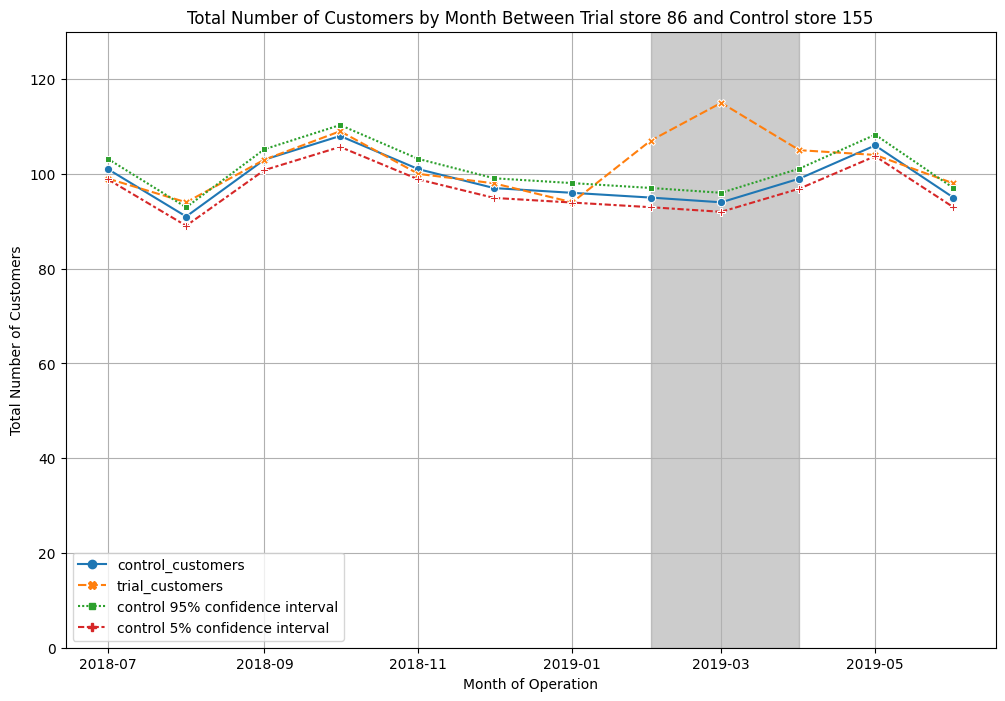

In [75]:
# Create plot for customers over time for control store and trial store
plt.figure(figsize = (12, 8))
sns.lineplot(data=combinecustomers, markers=True)

plt.title('Total Number of Customers by Month Between Trial store 86 and Control store 155')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.ylim((0, 130))
plt.axvspan(* mdates.datestr2num(['2019-02-01', '2019-04-01']), color='grey', alpha = 0.4)
plt.legend()
plt.grid()
plt.show()




It looks like the number of customers is significantly higher in all of the three months. This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
as we saw, sales were not significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices, impacting the results.

### Trial store 88

In [76]:
# We will use the two functions above to find the control store.
trial_store = 88
corr_nSales = calculate_correlations(pre_trial_full_observ, 'total_sales', storeComparison = trial_store)
corr_nCustomers = calculate_correlations(pre_trial_full_observ, 'number_customers', storeComparison = trial_store)

corr_nSales.head()


,store 1,store 2,correlation
0,88.0,1.0,0.823306
1,88.0,2.0,-0.151853
2,88.0,3.0,-0.288716
3,88.0,4.0,-0.619880
4,88.0,5.0,0.038594


In [77]:
corr_nCustomers.head()

,store 1,store 2,correlation
0,88.0,1.0,0.242805
1,88.0,2.0,-0.156135
2,88.0,3.0,0.341899
3,88.0,4.0,-0.122544
4,88.0,5.0,0.028866


In [78]:
# Use the functions for calculating magnitude
magnitude_nSales = calculate_magnitude_distance(pre_trial_full_observ, 'total_sales', storeComparison=trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_full_observ, 'number_customers', storeComparison=trial_store)

magnitude_nSales.head()


,store 1,store 2,magnitude
0,88.0,1.0,0.545494
1,88.0,2.0,0.502197
2,88.0,3.0,0.497161
3,88.0,4.0,0.637999
4,88.0,5.0,0.499593


In [79]:
magnitude_nCustomers.head()

,store 1,store 2,magnitude
0,88.0,1.0,0.401042
1,88.0,2.0,0.339286
2,88.0,3.0,0.523810
3,88.0,4.0,0.628788
4,88.0,5.0,0.534091


In [80]:
# Define correlation and magnitude weights
corr_weight = 0.5

# Combine correlation and magnitude scores for sales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['store 1', 'store 2'])
score_nSales['score_nSales'] = score_nSales['correlation'] * corr_weight + score_nSales['magnitude'] * (1 - corr_weight)

score_nSales

,store 1,store 2,correlation,magnitude,score_nSales
0,88.0,1.0,0.823306,0.545494,0.684400
1,88.0,2.0,-0.151853,0.502197,0.175172
2,88.0,3.0,-0.288716,0.497161,0.104222
3,88.0,4.0,-0.619880,0.637999,0.009059
4,88.0,5.0,0.038594,0.499593,0.269093
...,...,...,...,...,...
255,88.0,268.0,-0.100489,0.479415,0.189463
256,88.0,269.0,-0.165132,0.552234,0.193551
257,88.0,270.0,-0.737748,0.474242,-0.131753
258,88.0,271.0,-0.166019,0.382504,0.108242


In [81]:
# Combine correlation and magnitude scores for customers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['store 1', 'store 2'])
score_nCustomers['score_nCust'] = score_nCustomers['correlation'] * corr_weight + score_nCustomers['magnitude'] * (1 - corr_weight)

score_nCustomers

,store 1,store 2,correlation,magnitude,score_nCust
0,88.0,1.0,0.242805,0.401042,0.321924
1,88.0,2.0,-0.156135,0.339286,0.091576
2,88.0,3.0,0.341899,0.523810,0.432854
3,88.0,4.0,-0.122544,0.628788,0.253122
4,88.0,5.0,0.028866,0.534091,0.281478
...,...,...,...,...,...
255,88.0,268.0,0.668599,0.588235,0.628417
256,88.0,269.0,-0.214158,0.348684,0.067263
257,88.0,270.0,-0.045451,0.333333,0.143941
258,88.0,271.0,0.048096,0.625000,0.336548


In [82]:
# Combine scores across the drivers
composite_scores = score_nSales.merge(score_nCustomers, on=['store 1', 'store 2'])
composite_scores['combined_score'] = composite_scores['score_nSales'] * 0.5 + composite_scores['score_nCust'] * 0.5
composite_scores.head()



,store 1,store 2,correlation_x,magnitude_x,score_nSales,correlation_y,magnitude_y,score_nCust,combined_score
0,88.0,1.0,0.823306,0.545494,0.684400,0.242805,0.401042,0.321924,0.503162
1,88.0,2.0,-0.151853,0.502197,0.175172,-0.156135,0.339286,0.091576,0.133374
2,88.0,3.0,-0.288716,0.497161,0.104222,0.341899,0.523810,0.432854,0.268538
3,88.0,4.0,-0.619880,0.637999,0.009059,-0.122544,0.628788,0.253122,0.131091
4,88.0,5.0,0.038594,0.499593,0.269093,0.028866,0.534091,0.281478,0.275286


Select control stores based on the highest matching store (closest to 1 but not the store itself, i.e. the second ranked highest store)

In [83]:
# Select control store for trial store 88
control_store = composite_scores[composite_scores['store 1'] == trial_store].sort_values(by='combined_score', ascending=False).iloc[1]['store 2']
control_store




237.0

We’ve now found store 237 to be a suitable control store for trial store 88.
Again, let’s check visually if the drivers are indeed similar in the period before the trial.
We’ll look at total sales first.

In [84]:
control_store = 237

pastSales = pre_trial_full_observ

# create new column within 'pastSales which categories store stype 
store_type = []

for i in pastSales['store_number']:
    if i == trial_store:
        store_type.append('trial store')
    elif i == control_store:
        store_type.append('control store')
    else:
        store_type.append('other stores')

pastSales['store_type'] = store_type
pastSales['store_type'].unique()

pastSales.head()

<ipython-input-84-14d85e57aa90>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit,store_type
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097,other stores
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111,other stores
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333,other stores
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103,other stores
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947,other stores


In [85]:
# calculate mean sales for other stores
other_sales = pastSales.loc[pastSales['store_type'] == 'other stores', ['month', 'total_sales']]
other_sales_mean = other_sales.groupby('month').mean()
other_sales_mean.rename(columns={'total_sales': 'other stores'}, inplace=True)

# visual checks on Total Sales trends by comparing the trial store to the control store and other stores
store_types = ['control store', 'trial store', 'other stores']

sales_data = {}
for store_type in store_types:
    if store_type == 'other stores':
        sales = other_sales_mean
    else:
        sales = pastSales.loc[pastSales['store_type'] == store_type, ['month', 'total_sales']]
        sales.set_index('month', inplace=True)
        sales.rename(columns={'total_sales': store_type}, inplace=True)
    sales_data[store_type] = sales

control_store = sales_data['control store']
trial_store = sales_data['trial store']
other_stores = sales_data['other stores']

sales_data = pd.concat([control_store, trial_store, other_stores], axis=1)

sales_data


,control store,trial store,other stores
month,,,
2018-07,1448.4,1310.0,629.590310
2018-08,1367.8,1323.8,601.889341
2018-09,1322.2,1423.0,611.317054
2018-10,1348.3,1352.4,626.359302
2018-11,1397.6,1382.8,609.858527
2018-12,1265.0,1325.2,640.534884
2019-01,1219.7,1266.4,620.528682
2019-02,1404.8,1370.2,572.988372


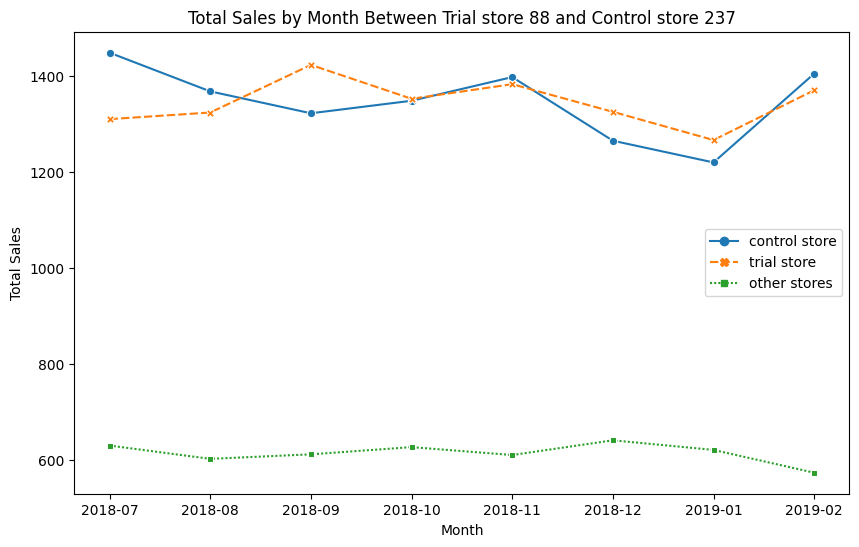

In [86]:
# plot for each store: Trial store 88: Control Store 237
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_data, markers=True)
plt.title('Total Sales by Month Between Trial store 88 and Control store 237')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


Great, the trial and control stores have similar total sales.
Next, number of customers.

In [87]:
# calculate mean customers for other stores
other_customers = pastSales.loc[pastSales['store_type'] == 'other stores', ['month', 'number_customers']]
other_customers_mean = other_customers.groupby('month').mean()
other_customers_mean.rename(columns={'number_customers': 'other stores'}, inplace=True)

# visual checks on Number Customers trends by comparing the trial store to the control store and other stores
store_types = ['control store', 'trial store', 'other stores']

customers_data = {}
for store_type in store_types:
    if store_type == 'other stores':
        customers = other_customers_mean
    else:
        customers = pastSales.loc[pastSales['store_type'] == store_type, ['month', 'number_customers']]
        customers.set_index('month', inplace=True)
        customers.rename(columns={'number_customers': store_type}, inplace=True)
    customers_data[store_type] = customers

control_store = customers_data['control store']
trial_store = customers_data['trial store']
other_stores = customers_data['other stores']

customers_data = pd.concat([control_store, trial_store, other_stores], axis=1)

customers_data


,control store,trial store,other stores
month,,,
2018-07,128,129,71.732558
2018-08,135,131,71.457364
2018-09,126,124,69.488372
2018-10,123,123,70.934109
2018-11,132,130,69.833333
2018-12,124,126,72.906977
2019-01,117,117,70.604651
2019-02,126,124,65.856589


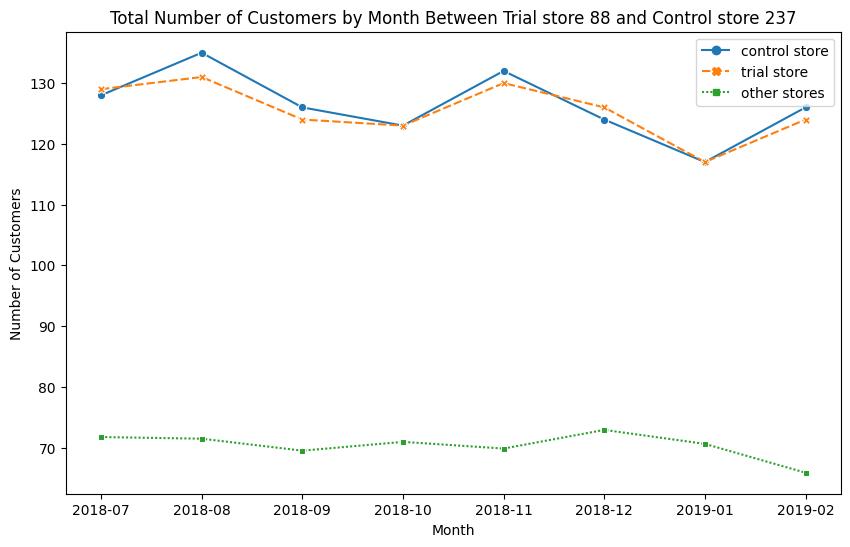

In [88]:
# plot for each store: Trial store 88 and Control store 237
plt.figure(figsize=(10, 6))
sns.lineplot(data=customers_data, markers=True)
plt.title('Total Number of Customers by Month Between Trial store 88 and Control store 237')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()



Total number of customers of the control and trial stores are also similar.
Let’s now assess the impact of the trial on sales.

In [89]:


# Scale pre‐trial control sales to match pre‐trial trial store sales
scaling_factor_controlSales = pastSales[(pastSales['store_type'] == 'trial store') & (pastSales['month'] < '2019-02')]['total_sales'].sum() / \
                                 pastSales[(pastSales['store_type'] == 'control store') & (pastSales['month'] < '2019-02')]['total_sales'].sum()      

print('Scaling factor for control sales:', scaling_factor_controlSales)



Scaling factor for control sales: 1.001558330664959


In [90]:
# Apply the scaling factor
control_store = 237
scaled_ControlSales = metrics.loc[metrics['store_number'] == control_store]

scaled_ControlSales['control_sales'] = scaled_ControlSales['total_sales'] * scaling_factor_controlSales
scaled_ControlSales.head()


<ipython-input-90-9eb3a590fc0f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_ControlSales['control_sales'] = scaled_ControlSales['total_sales'] * scaling_factor_controlSales


,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit,control_sales
2747,237,2018-07,1448.4,128,1.265625,2.000000,4.470370,1450.657086
2748,237,2018-08,1367.8,135,1.222222,1.896970,4.369968,1369.931485
2749,237,2018-09,1322.2,126,1.182540,2.006711,4.422074,1324.260425
2750,237,2018-10,1348.3,123,1.195122,2.034014,4.509365,1350.401097
2751,237,2018-11,1397.6,132,1.219697,1.987578,4.367500,1399.777923


In [91]:
# Create 'percentage_diff' dataframec and merge the scaled control sales and trial sales based on month
trial_store = 88
merged_sales = scaled_ControlSales[['month', 'control_sales']].merge(metrics[metrics['store_number'] == trial_store][['total_sales', 'month']],
                                                                     on='month', how='inner')

merged_sales.rename(columns={'total_sales': 'trial_sales'}, inplace=True)

merged_sales['percentage_diff'] = abs(merged_sales['control_sales'] - merged_sales['trial_sales']) / merged_sales['control_sales']

merged_sales



,month,control_sales,trial_sales,percentage_diff
0,2018-07,1450.657086,1310.00,0.096961
1,2018-08,1369.931485,1323.80,0.033674
2,2018-09,1324.260425,1423.00,0.074562
3,2018-10,1350.401097,1352.40,0.001480
4,2018-11,1399.777923,1382.80,0.012129
5,2018-12,1266.971288,1325.20,0.045959
6,2019-01,1221.600696,1266.40,0.036673
7,2019-02,1406.989143,1370.20,0.026147
8,2019-03,1210.082775,1477.20,0.220743
9,2019-04,1206.477165,1439.40,0.193060


In [92]:
# As our null hypothesis is that the trial period is the same as the  pre‐trial period, 
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

# Statistics Libraries
from statistics import stdev
from scipy.stats import t


# calculate standard deviation of percentage difference during pre-trial period
stdDev = stdev(merged_sales.loc[merged_sales['month'] < '2019-02', 'percentage_diff'])
print(f'Standard deviation: {stdDev} \n')


# note that there are 8 months in the pre‐trial period hence 8 ‐ 1 = 7 degrees of freedom
degrees_of_freedom = 7

# We will test with a null hypothesis of there being 0 difference between  trial and control stores.
merged_sales['tValue'] = (merged_sales['percentage_diff'] - 0) / stdDev
t_values = merged_sales.loc[(merged_sales['month'] < '2019-05') & (merged_sales['month'] > '2019-01'), ['month', 'tValue']]
print(t_values)


# calculate 95th percentile of t-distribution with appropriate degrees of freedom
t_crit = t.ppf(0.95, df=degrees_of_freedom)
print(f'\n T-critical value: {t_crit}')


Standard deviation: 0.0334678673030788 

     month    tValue
7  2019-02  0.781270
8  2019-03  6.595668
9  2019-04  5.768527

 T-critical value: 1.894578605061305


In [93]:
# calculate for the 95th percentile value of sales of the control store.
sale_over_time = merged_sales.loc[:, ['month','control_sales', 'trial_sales']]
sale_over_time['control 95% confidence interval'] = sale_over_time['control_sales'] * (1 + stdDev * 2)
sale_over_time['control 5% confidence interval'] = sale_over_time['control_sales'] * (1 - stdDev * 2)
sale_over_time['transaction_month'] = pd.to_datetime(sale_over_time['month'].astype(str), format = '%Y-%m')

combineSales = sale_over_time.loc[:, ['transaction_month','control_sales', 'trial_sales', 'control 95% confidence interval', 'control 5% confidence interval']].set_index('transaction_month')

combineSales


,control_sales,trial_sales,control 95% confidence interval,control 5% confidence interval
transaction_month,,,,
2018-07-01,1450.657086,1310.00,1547.757884,1353.556288
2018-08-01,1369.931485,1323.80,1461.628855,1278.234114
2018-09-01,1324.260425,1423.00,1412.900769,1235.620080
2018-10-01,1350.401097,1352.40,1440.791187,1260.011008
2018-11-01,1399.777923,1382.80,1493.473086,1306.082759
2018-12-01,1266.971288,1325.20,1351.776942,1182.165634
2019-01-01,1221.600696,1266.40,1303.369436,1139.831956
2019-02-01,1406.989143,1370.20,1501.166995,1312.811291
2019-03-01,1210.082775,1477.20,1291.080555,1129.084996


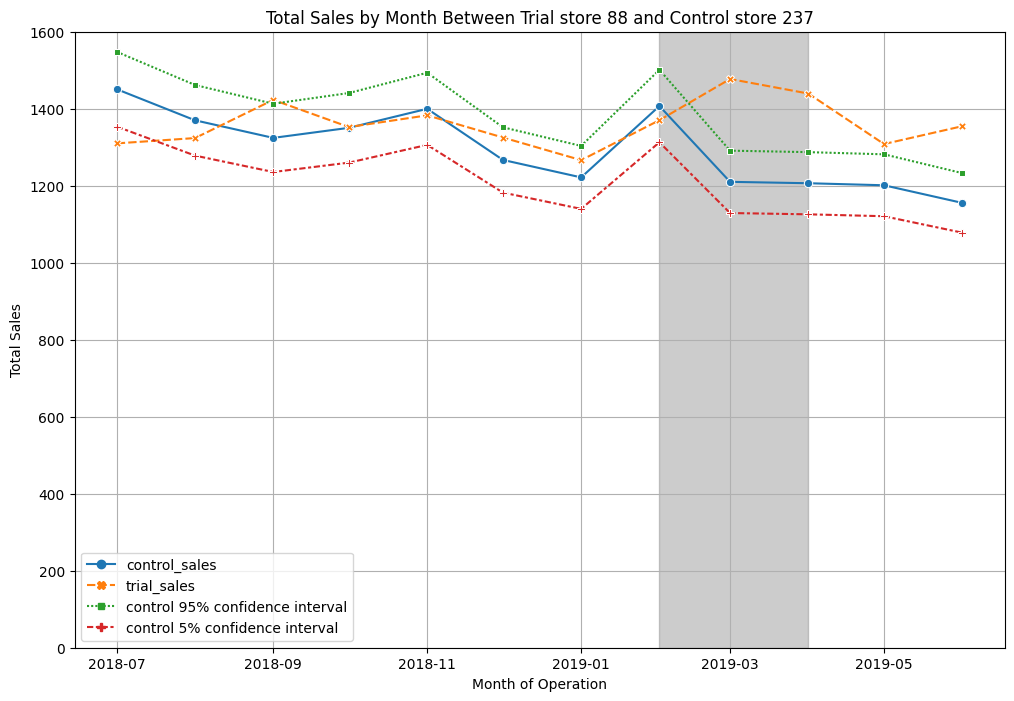

In [94]:
import matplotlib.dates as mdates

# Create plot for sales over time for control store and trial store
plt.figure(figsize = (12, 8))
sns.lineplot(data=combineSales, markers=True)

plt.title('Total Sales by Month Between Trial store 88 and Control store 237')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.ylim((0, 1600))
plt.axvspan(* mdates.datestr2num(['2019-02-01', '2019-04-01']), color='grey', alpha = 0.4)
plt.legend()
plt.grid()
plt.show()


The results show that the trial in store 88 is significantly different to its control store in the trial period as the
trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the
three trial months.

Let’s have a look at assessing this for number of customers as well.

In [95]:
# Scale pre‐trial control customers to match pre‐trial trial store customers
scaling_factor_controlCustomers = pastSales[(pastSales['store_type'] == 'trial store') & (pastSales['month'] < '2019-02')]['number_customers'].sum() / \
                                 pastSales[(pastSales['store_type'] == 'control store') & (pastSales['month'] < '2019-02')]['number_customers'].sum()      

print('Scaling factor for control sales:', scaling_factor_controlCustomers)


Scaling factor for control sales: 0.9943502824858758


In [96]:
# Apply the scaling factor
control_store = 237
scaled_ControlCustomers = metrics.loc[metrics['store_number'] == control_store]

scaled_ControlCustomers['control_customers'] = scaled_ControlCustomers['number_customers'] * scaling_factor_controlCustomers
scaled_ControlCustomers.head()


<ipython-input-96-ca4993f9779f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_ControlCustomers['control_customers'] = scaled_ControlCustomers['number_customers'] * scaling_factor_controlCustomers


,store_number,month,total_sales,number_customers,transactions_per_customer,chips_per_transaction,avg_price_per_unit,control_customers
2747,237,2018-07,1448.4,128,1.265625,2.000000,4.470370,127.276836
2748,237,2018-08,1367.8,135,1.222222,1.896970,4.369968,134.237288
2749,237,2018-09,1322.2,126,1.182540,2.006711,4.422074,125.288136
2750,237,2018-10,1348.3,123,1.195122,2.034014,4.509365,122.305085
2751,237,2018-11,1397.6,132,1.219697,1.987578,4.367500,131.254237


In [97]:
# Create 'percentage_diff' dataframe and merge the scaled control Customers and trial Customers based on month
trial_store = 88
merged_Customers = scaled_ControlCustomers[['month', 'control_customers']].merge(metrics[metrics['store_number'] == trial_store][['number_customers', 'month']],
                                                                     on='month', how='inner')

merged_Customers.rename(columns={'number_customers': 'trial_customers'}, inplace=True)

merged_Customers['percentage_diff'] = abs(merged_Customers['control_customers'] - merged_Customers['trial_customers']) / merged_Customers['control_customers']

merged_Customers

,month,control_customers,trial_customers,percentage_diff
0,2018-07,127.276836,129,0.013539
1,2018-08,134.237288,131,0.024116
2,2018-09,125.288136,124,0.010281
3,2018-10,122.305085,123,0.005682
4,2018-11,131.254237,130,0.009556
5,2018-12,123.299435,126,0.021902
6,2019-01,116.338983,117,0.005682
7,2019-02,125.288136,124,0.010281
8,2019-03,118.327684,134,0.132448
9,2019-04,119.322034,128,0.072727


In [98]:
# As our null hypothesis is that the trial period is the same as the  pre‐trial period, 
# let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

# Statistics Libraries
from statistics import stdev
from scipy.stats import t


# calculate standard deviation of percentage difference during pre-trial period
stdDev = stdev(merged_Customers.loc[merged_Customers['month'] < '2019-02', 'percentage_diff'])
print(f'Standard deviation: {stdDev} \n')


# note that there are 8 months in the pre‐trial period hence 8 ‐ 1 = 7 degrees of freedom
degrees_of_freedom = 7

# We will test with a null hypothesis of there being 0 difference between  trial and control stores.
merged_Customers['tValue'] = (merged_Customers['percentage_diff'] - 0) / stdDev
t_values = merged_Customers.loc[(merged_Customers['month'] < '2019-05') & (merged_Customers['month'] > '2019-01'), ['month', 'tValue']]
print(t_values)


# calculate 95th percentile of t-distribution with appropriate degrees of freedom
t_crit = t.ppf(0.95, df=degrees_of_freedom)
print(f'\n T-critical value: {t_crit}')


Standard deviation: 0.00741024435207507 

     month     tValue
7  2019-02   1.387456
8  2019-03  17.873693
9  2019-04   9.814423

 T-critical value: 1.894578605061305


In [99]:
# calculate for the 95th percentile value of sales of the control store.
customers_over_time = merged_Customers.loc[:, ['month','control_customers', 'trial_customers']]
customers_over_time['control 95% confidence interval'] = customers_over_time ['control_customers'] * (1 + stdDev * 2)
customers_over_time['control 5% confidence interval'] = customers_over_time ['control_customers'] * (1 - stdDev * 2)
customers_over_time['transaction_month'] = pd.to_datetime(customers_over_time ['month'].astype(str), format = '%Y-%m')

combinecustomers = customers_over_time.loc[:, ['transaction_month','control_customers', 'trial_customers', 'control 95% confidence interval', 'control 5% confidence interval']].set_index('transaction_month')

combinecustomers



,control_customers,trial_customers,control 95% confidence interval,control 5% confidence interval
transaction_month,,,,
2018-07-01,127.276836,129,129.163141,125.390531
2018-08-01,134.237288,131,136.226750,132.247826
2018-09-01,125.288136,124,127.144967,123.431304
2018-10-01,122.305085,123,124.117706,120.492464
2018-11-01,131.254237,130,133.199489,129.308985
2018-12-01,123.299435,126,125.126793,121.472077
2019-01-01,116.338983,117,118.063184,114.614782
2019-02-01,125.288136,124,127.144967,123.431304
2019-03-01,118.327684,134,120.081358,116.574010


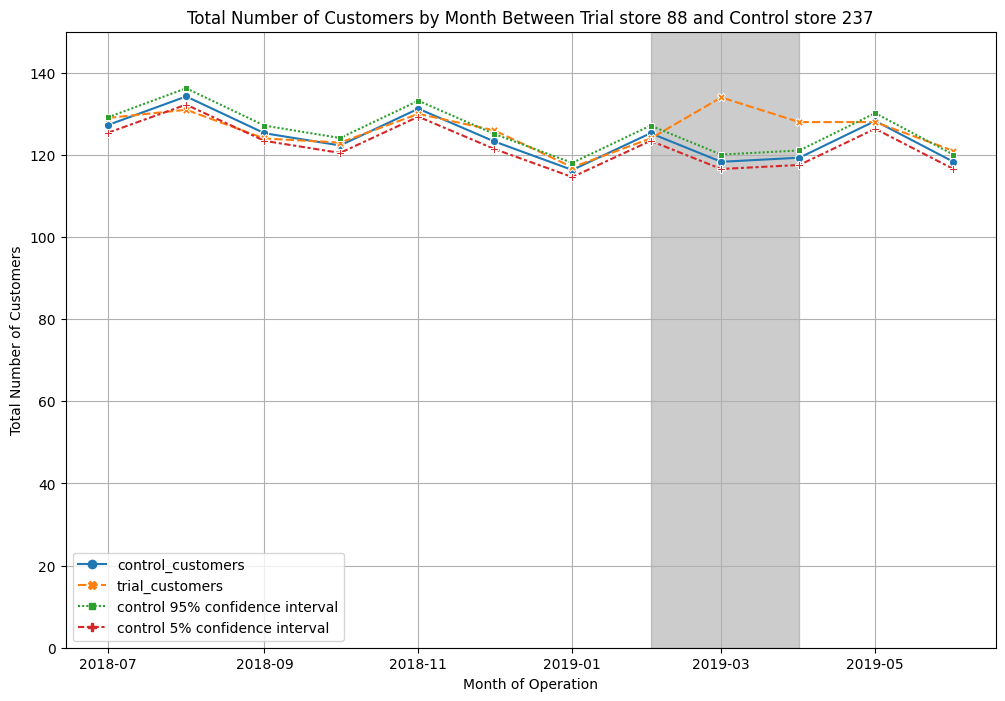

In [100]:
# Create plot for customers over time for control store and trial store
plt.figure(figsize = (12, 8))
sns.lineplot(data=combinecustomers, markers=True)

plt.title('Total Number of Customers by Month Between Trial store 88 and Control store 237')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.ylim((0, 150))
plt.axvspan(* mdates.datestr2num(['2019-02-01', '2019-04-01']), color='grey', alpha = 0.4)
plt.legend()
plt.grid()
plt.show()




Total number of customers in the trial period for the trial store is significantly higher than the control store
for two out of three months, which indicates a positive trial effect.

### Conclusion

I found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.

The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86. We can check with the client if the implementation
of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. 

Now that
we have finished our analysis, we can prepare our presentation to the Category Manager.